In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/embed-mean/emeddings_bert_mean.txt
/kaggle/input/click-data/clicks_new - clicks.csv
/kaggle/input/article-embeddings/emeddings_bert.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.200d.txt
/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.50d.txt
/kaggle/input/news-article/news_articles.csv


In [7]:
df=pd.read_csv('/kaggle/input/news-article/news_articles.csv')
df_clicks=pd.read_csv('/kaggle/input/click-data/clicks_new - clicks.csv')

In [8]:
df.head(5)

,Article_Id,Title,Author,Date,Content,URL
0,0,14 dead after bus falls into canal in Telangan...,Devyani Sultania,"August 22, 2016 12:34 IST",At least 14 people died and 17 others were inj...,http://www.ibtimes.co.in/14-dead-after-bus-fal...
1,1,Pratibha Tiwari molested on busy road Saath ...,Suparno Sarkar,"August 22, 2016 19:47 IST",TV actress Pratibha Tiwari who is best known ...,NaN
2,2,US South Korea begin joint military drill ami...,Namrata Tripathi,"August 22, 2016 18:10 IST",The United States and South Korea began a join...,http://www.ibtimes.co.in/us-south-korea-begin-...
3,3,Illegal construction in Bengaluru Will my hou...,S V Krishnamachari,"August 22, 2016 17:39 IST",The relentless drive by Bengaluru s Bangalore...,http://www.ibtimes.co.in/illegal-construction-...
4,4,Punjab Gau Rakshak Dal chief held for assaulti...,Pranshu Rathee,"August 22, 2016 17:34 IST",Punjab Gau Raksha Dal chief Satish Kumar and h...,http://www.ibtimes.co.in/punjab-gau-rakshak-da...


In [11]:
df.shape

(4831, 6)

In [12]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [13]:
titles=list(df['Title'])
content=list(df['Content'])
titles[:10]

['14 dead after bus falls into canal in Telangana s Khammam district  Andhra CM promises Rs 3 lakh compensation',
 'Pratibha Tiwari molested on busy road   Saath Nibhana Saathiya  actress drags accused to police station',
 'US  South Korea begin joint military drill amid nuclear threat from North Korea',
 'Illegal construction in Bengaluru  Will my house be demolished next  ask worried residents',
 'Punjab Gau Rakshak Dal chief held for assaulting  sodomising cattle traders',
 'Phillipines drug war  1 800 drug-related deaths since June-end',
 'Infosys shares likely to fall on Tuesday after company s client RBS scraps Williams   Glyn project',
 'Dialogue crucial in finding permanent solution to Kashmir s crisis  PM Modi',
 'School bus overturns in Jammu killing 1 and injuring 16 children',
 'Rajasthan  Villagers rescue 50 kids after school bus falls into river in Bhilwara']

stopwords , stemming , tokenizing

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens



In [15]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in content:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [16]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 1244340 items in vocab_frame


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=10, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(content) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 49.6 s, sys: 938 ms, total: 50.5 s
Wall time: 50.5 s
(4831, 11561)


In [ ]:
from sklearn.cluster import KMeans
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
find_optimal_clusters(tfidf_matrix, 10)

In [18]:

from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

clusters=km.fit_predict(tfidf_matrix)


In [19]:
clusters

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

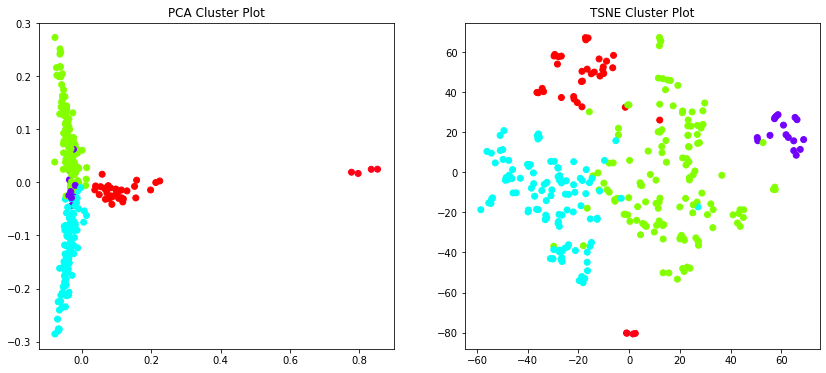

In [21]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(tfidf_matrix, clusters)

In [22]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_matrix, clusters, tfidf_vectorizer.get_feature_names(), 15)


Cluster 0
batteri,launch,updat,note,phone,new,samsung,xiaomi,oneplus,camera,android,featur,galaxi,smartphon,devic

Cluster 1
indian,rs,kill,isi,peopl,year,state,minist,attack,polic,govern,india,report,s,said

Cluster 2
director,role,bollywood,box,box offic,star,song,actress,releas,actor,khan,salman,s,movi,film

Cluster 3
team,player,event,athlet,saina,world,s,match,win,rio olymp,india,medal,game,rio,olymp

Cluster 4
user,zip file,file,devic,note,select,procedur,zip,android,recoveri,custom,custom rom,rom,step,instal


In [23]:
from collections import Counter
Counter(clusters)

Counter({1: 2355, 2: 1473, 3: 337, 0: 545, 4: 121})

* **** cluster 0:
* **** cluster 1:
* **** cluster 2:
* **** cluster 3:
* **** cluster 4:
# Prediction

In [24]:
new_article=['KARACHI: Seven Pakistani soldiers were killed in two separate terror attacks in the restive Balochistan province, an official statement said on Tuesday. Terrorists targeted a vehicle of the Frontier Corps using improvised explosive devices in the Pir Ghaib area on Monday night, killing six Pakistan Army soldiers, said Inter-Services Public Relations (ISPR), the media wing of the Pakistani military. In a separate incident in Balochistan Kech, another soldier was killed during an exchange of fire with the militants.Resource-rich Balochistan in southwestern Pakistan borders Afghanistan and Iran, But it is also Pakistan largest and poorest province, rife with ethnic, sectarian and separatist insurgencies.']
unseen_tfidf = tfidf_vectorizer.transform(new_article)
km.predict(unseen_tfidf)

array([1], dtype=int32)

**article id's for each clusters**


In [25]:
cluster0_index= []
cluster1_index= []
cluster2_index= []
cluster3_index= []
cluster4_index= []
for i in range(0,len(clusters)-1):
    if clusters[i]==0:
        cluster0_index.append(i)
for i in range(0,len(clusters)-1):
    if clusters[i]==1:
        cluster1_index.append(i)
for i in range(0,len(clusters)-1):
    if clusters[i]==2:
        cluster2_index.append(i)
for i in range(0,len(clusters)-1):
    if clusters[i]==3:
        cluster3_index.append(i)
for i in range(0,len(clusters)-1):
    if clusters[i]==4:
        cluster4_index.append(i)
len(cluster2_index)

1473

# without user prefrences (recommend either randomly or breaking news from each cluster )

In [26]:
#randomly
import random
sampling0 = random.choices(cluster0_index, k=2)
sampling1 = random.choices(cluster1_index, k=2)
sampling2 = random.choices(cluster2_index, k=2)
sampling3 = random.choices(cluster3_index, k=2)
sampling4 = random.choices(cluster4_index, k=2)
show_list=[sampling0,sampling1,sampling2,sampling3,sampling4]
recommend_index=[]
for x in show_list:
    for ele in x:
        recommend_index.append(ele)
n=0
print('Articles Recommended for you :) ')
for i in recommend_index:
    n=n+1
    print('Article ',n,': ',df['Title'][i])

Articles Recommended for you :) 
Article  1 :  OnePlus 3 release date  specifications  How will it stack up against OnePlus 2 
Article  2 :  Moto E  2nd Gen  Review  Budget Smartphone with Decent Battery  Lollipop OS but Average Camera
Article  3 :  Maharashtra minister Eknath Khadse resigns  Congress demands criminal case against the BJP leader
Article  4 :  Ambani Brothers to Join Hands to Offer 4G Services  Report
Article  5 :   Enne Thallenda Ammava  Song of  Oru Vadakkan Selfie  Starring Nivin  Aju  Neeraj Released  VIDEO 
Article  6 :  Will Salman Khan s  Sultan  second teaser feature only Anushka Sharma 
Article  7 :  Sachin Tendulkar meets Indian wrestlers who will participate in Rio Olympics
Article  8 :  Vijender Singh defeats Alexander Horvath for his fourth straight win
Article  9 :  Update Samsung Galaxy Note 5 with Android 6 0 Marshmallow via CyanogenMod 13 ROM  How to install 
Article  10 :  Install Android 5 1 1 Lollipop Custom ROM on Samsung Galaxy S4 via BlissPop  How

In [27]:
#Breaking news
df1=df.copy()
df1.isna(). sum()

Article_Id       0
Title            0
Author           6
Date             5
Content          0
URL           1442
dtype: int64

In [28]:
df1=df1.dropna(subset=['Date'])
df1.shape

(4826, 6)

In [29]:
df1[df1['Date'] == ' Saranya Ponvannan']
df1=df1.drop(544)

In [30]:
import datetime
df1['Date'] = df1['Date'].astype('datetime64[ns]') 

/opt/conda/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [31]:
df1=df1.sort_values(by="Date")
df1.head(5)

,Article_Id,Title,Author,Date,Content,URL
2148,2148,Indian Cinema Biggest Grossers of 2011,Raymond Ronamai,2011-12-10 16:08:00,2011 is not a bad for Indian cinema Quite a g...,http://www.ibtimes.co.in/indian-cinema-biggest...
2510,2510,India Beats China U S In Personal Computer S...,Raymond Ronamai,2012-06-04 23:36:00,India is ahead of United States Japan and Chi...,http://www.ibtimes.co.in/india-beats-china-u-s...
26,26,Forensic Report Rules Out Sabotage As Cause Be...,Manoj Kumar,2012-07-01 17:08:00,A forensic report by Central Forensic Science ...,NaN
2945,2945,India s Western Ghats Added to List of UNESCO ...,Sangeetha Seshagiri,2012-07-02 15:11:00,The United Nations Educational Scientific and...,NaN
2964,2964,Guwahati Girl Molestation Case Two More Arres...,Manoj Kumar,2012-07-15 15:18:00,Nearly a week after the molestation of a girl ...,http://www.ibtimes.co.in/guwahati-girl-molesta...


In [32]:
list_article=list(df1['Article_Id'])
cluster0_date_index=[]
cluster1_date_index=[]
cluster2_date_index=[]
cluster3_date_index=[]
cluster4_date_index=[]
for i in cluster0_index:
    if i in list_article:
        cluster0_date_index.append(i)
for i in cluster1_index:
    if i in list_article:
        cluster1_date_index.append(i)
for i in cluster2_index:
    if i in list_article:
        cluster2_date_index.append(i)
for i in cluster3_index:
    if i in list_article:
        cluster3_date_index.append(i)
for i in cluster4_index:
    if i in list_article:
        cluster4_date_index.append(i)

In [33]:
import operator
dict0={}
dict1={}
dict2={}
dict3={}
dict4={}
for i in cluster0_date_index:
    dict0[i]=df1['Date'][i]
dict0 = sorted(dict0.items(), key=operator.itemgetter(1))
for i in cluster1_date_index:
    dict1[i]=df1['Date'][i]
dict1 = sorted(dict1.items(), key=operator.itemgetter(1))
for i in cluster2_date_index:
    dict2[i]=df1['Date'][i]
dict2 = sorted(dict2.items(), key=operator.itemgetter(1))
for i in cluster3_date_index:
    dict3[i]=df1['Date'][i]
dict3 = sorted(dict3.items(), key=operator.itemgetter(1))
for i in cluster4_date_index:
    dict4[i]=df1['Date'][i]
dict4 = sorted(dict4.items(), key=operator.itemgetter(1))

In [34]:
#breaking news recommendation from each cluster
x1=dict0[-2:][0][0]
x2=dict0[-2:][1][0]
x3=dict1[-2:][0][0]
x4=dict1[-2:][1][0]
x5=dict2[-2:][0][0]
x6=dict2[-2:][1][0]
x7=dict3[-2:][0][0]
x8=dict3[-2:][1][0]
x9=dict4[-2:][0][0]
x10=dict4[-2:][1][0]
list_breaking=[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
n=0
print("Breaking News Recommendation:):")
for i in list_breaking:
    n=n+1
    print('Article ',n,': ',df['Title'][i])


Breaking News Recommendation:):
Article  1 :  Batman-inspired Samsung Galaxy Note7 edition images leaked  key design elements revealed
Article  2 :  Gionee S6s with 8MP front camera  LED flash launched in India  price  specifications
Article  3 :  MQM chief Hussain charged with treason for his  Pakistan is cancer for the world  remark
Article  4 :  BREAKING  Vinay Sharma  Nirbhaya rape convict  attempts suicide in Tihar  hospitalised
Article  5 :  Shoot of Salman Khan s  Tubelight  put on hold indefinitely 
Article  6 :  Did  Great Grand Masti  actress Urvashi Rautela ditch Dubai Fashion Week organisers for more money 
Article  7 :  Rio 2016  Narsingh Yadav believes his dream of winning Olympics medal has been cruelly snatched away
Article  8 :  Rio Olympics  People in India told WADA to review my case  says Narsingh Yadav
Article  9 :  Samsung Galaxy Note 3 gets Android Marshmallow via OrionOS  unofficial  custom ROM  How to install 
Article  10 :  Samsung Galaxy S4 gets new Android M

recommend famous news articles

In [37]:
df['click_count']=list(df_clicks['Total_clicks'])
df.head(5)

,Article_Id,Title,Author,Date,Content,URL,click_count
0,0,14 dead after bus falls into canal in Telangan...,Devyani Sultania,"August 22, 2016 12:34 IST",At least 14 people died and 17 others were inj...,http://www.ibtimes.co.in/14-dead-after-bus-fal...,8
1,1,Pratibha Tiwari molested on busy road Saath ...,Suparno Sarkar,"August 22, 2016 19:47 IST",TV actress Pratibha Tiwari who is best known ...,NaN,4
2,2,US South Korea begin joint military drill ami...,Namrata Tripathi,"August 22, 2016 18:10 IST",The United States and South Korea began a join...,http://www.ibtimes.co.in/us-south-korea-begin-...,2
3,3,Illegal construction in Bengaluru Will my hou...,S V Krishnamachari,"August 22, 2016 17:39 IST",The relentless drive by Bengaluru s Bangalore...,http://www.ibtimes.co.in/illegal-construction-...,5
4,4,Punjab Gau Rakshak Dal chief held for assaulti...,Pranshu Rathee,"August 22, 2016 17:34 IST",Punjab Gau Raksha Dal chief Satish Kumar and h...,http://www.ibtimes.co.in/punjab-gau-rakshak-da...,5


In [38]:
import operator
dict_click0={}
dict_click1={}
dict_click2={}
dict_click3={}
dict_click4={}
for i in cluster0_index:
    dict_click0[i]=df['click_count'][i]
dict_click0 = sorted(dict_click0.items(), key=operator.itemgetter(1))
for i in cluster1_index:
    dict_click1[i]=df['click_count'][i]
dict_click1 = sorted(dict_click1.items(), key=operator.itemgetter(1))
for i in cluster2_index:
    dict_click2[i]=df['click_count'][i]
dict_click2 = sorted(dict_click2.items(), key=operator.itemgetter(1))
for i in cluster3_index:
    dict_click3[i]=df['click_count'][i]
dict_click3 = sorted(dict_click3.items(), key=operator.itemgetter(1))
for i in cluster4_index:
    dict_click4[i]=df['click_count'][i]
dict_click4 = sorted(dict_click4.items(), key=operator.itemgetter(1))
dict_click4

[(1028, 0),
 (908, 1),
 (960, 1),
 (1039, 1),
 (1047, 1),
 (1050, 1),
 (911, 2),
 (966, 2),
 (883, 3),
 (952, 3),
 (1068, 3),
 (1079, 3),
 (1195, 3),
 (1199, 3),
 (1207, 3),
 (1216, 3),
 (1225, 3),
 (1246, 3),
 (1290, 3),
 (1299, 3),
 (1300, 3),
 (4059, 3),
 (874, 4),
 (910, 4),
 (947, 4),
 (953, 4),
 (954, 4),
 (1027, 4),
 (1037, 4),
 (1042, 4),
 (1044, 4),
 (1109, 4),
 (1196, 4),
 (1204, 4),
 (1210, 4),
 (1213, 4),
 (1217, 4),
 (1231, 4),
 (1232, 4),
 (1241, 4),
 (1242, 4),
 (1245, 4),
 (1247, 4),
 (4151, 4),
 (4278, 4),
 (884, 5),
 (906, 5),
 (909, 5),
 (950, 5),
 (957, 5),
 (1036, 5),
 (1052, 5),
 (1059, 5),
 (1069, 5),
 (1074, 5),
 (1206, 5),
 (1209, 5),
 (1226, 5),
 (1229, 5),
 (1230, 5),
 (1240, 5),
 (1279, 5),
 (1289, 5),
 (4157, 5),
 (4282, 5),
 (881, 6),
 (904, 6),
 (1038, 6),
 (1040, 6),
 (1053, 6),
 (1200, 6),
 (1211, 6),
 (1215, 6),
 (1219, 6),
 (1220, 6),
 (1224, 6),
 (1227, 6),
 (1228, 6),
 (1234, 6),
 (1243, 6),
 (1288, 6),
 (1291, 6),
 (1301, 6),
 (1341, 6),
 (1417, 6)

In [40]:
#breaking news recommendation from each cluster
y1=dict_click0[-2:][0][0]
y2=dict_click0[-2:][1][0]
y3=dict_click1[-2:][0][0]
y4=dict_click1[-2:][1][0]
y5=dict_click2[-2:][0][0]
y6=dict_click2[-2:][1][0]
y7=dict_click3[-2:][0][0]
y8=dict_click3[-2:][1][0]
y9=dict_click4[-2:][0][0]
y10=dict_click4[-2:][1][0]
list_famous=[y1,y2,y3,y4,y5,y6,y7,y8,y9,y10]
n=0
print("Frequently viewed News Articles:")
for i in list_famous:
    n=n+1
    print('Article ',n,': ',df['Title'][i])

Frequently viewed News Articles:
Article  1 :  Huawei Honor Bee First Impression  Amazing Budget Smartphone with Decent Specifications at Just  4 999
Article  2 :  Xiaomi MIUI 8 0 release date announced  key features  list of eligible devices
Article  3 :  Anti-India slogans will not be tolerated  Home Minister Rajnath Singh warns over JNU row  students  union president arrested
Article  4 :  Railways to invite bids for modernising 400 stations  says finance minister Arun Jaitley
Article  5 :   Tamasha  trailer out  Ranbir Kapoor-Deepika Padukone s chemistry captures hearts again  VIDEO 
Article  6 :  AP T box office  Dilwale  Bajirao Mastani take a toll on Loafer  Nava Manmadhudu collection
Article  7 :  Sania Mirza Martina Hingis vs Mugurza Suarez Navarro live streaming and TV information  Watch WTA Tour Finals doubles live
Article  8 :  2016 Rio Olympics  Vijender Singh unclear over representing India
Article  9 :  Update Moto G  aka Falcon  with Tesla Android 5 1 1 Lollipop Custom 

BERT embeddings

In [ ]:
import pickle
objects = []
with (open("/kaggle/input/embed-mean/emeddings_bert_mean.txt", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
embed_list=[]
for x in objects[0]:
    emb_np=x.cpu().detach().numpy()
    embed_list.append(emb_np)

In [ ]:
len(embed_list)

In [ ]:
from sklearn.cluster import KMeans
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
find_optimal_clusters(embed_list, 10)

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

clusters=km.fit_predict(embed_list)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
emd_arr=np.array(embed_list)

In [ ]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(emd_arr, clusters)

In [ ]:
from collections import Counter
Counter(clusters)

# Cluster0

In [ ]:
cluster0_index= []
for i in range(0,len(clusters)-1):
    if clusters[i]==0:
        cluster0_index.append(i)


In [ ]:
cluster0_articles=[]
for i in cluster0_index:
    cluster0_articles.append(df['Content'][i])
len(cluster0_articles)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=10, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(cluster0_articles) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
def display_scores(vectorizer, tfidf_result):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores:
        print("{0:50} Score: {1}".format(item[0], item[1]))

In [ ]:
display_scores(tfidf_vectorizer, tfidf_matrix)

# cluster 1

In [ ]:
cluster1_index= []
for i in range(0,len(clusters)-1):
    if clusters[i]==1:
        cluster1_index.append(i)
cluster1_articles=[]
for i in cluster1_index:
    cluster1_articles.append(df['Content'][i])
len(cluster1_articles)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=10, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(cluster1_articles) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
display_scores(tfidf_vectorizer, tfidf_matrix)

# cluster 2

In [ ]:
cluster2_index= []
for i in range(0,len(clusters)-1):
    if clusters[i]==2:
        cluster2_index.append(i)
cluster2_articles=[]
for i in cluster2_index:
    cluster2_articles.append(df['Content'][i])
len(cluster2_articles)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=5, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(cluster2_articles) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
display_scores(tfidf_vectorizer, tfidf_matrix)

# Cluster 3

In [ ]:
cluster3_index= []
for i in range(0,len(clusters)-1):
    if clusters[i]==3:
        cluster3_index.append(i)
cluster3_articles=[]
for i in cluster3_index:
    cluster3_articles.append(df['Content'][i])
len(cluster3_articles)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=5, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(cluster3_articles) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
display_scores(tfidf_vectorizer, tfidf_matrix)

# cluster 4

In [ ]:
cluster4_index= []
for i in range(0,len(clusters)-1):
    if clusters[i]==4:
        cluster4_index.append(i)
cluster4_articles=[]
for i in cluster4_index:
    cluster4_articles.append(df['Content'][i])
len(cluster4_articles)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=5, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(cluster4_articles) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
display_scores(tfidf_vectorizer, tfidf_matrix)